# Imports

In [1]:
import math
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import os
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras import Input, Model, backend
from keras.callbacks import Callback
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

from functions.predict_glucose import predict_glucose
from functions.load_data import load_data
#from functions.data_prep import data_prep
from functions.fill_missing_glucose_values import fill_missing_glucose_values


os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Defenição de parâmetros

In [2]:
datasets_train = [0, 2, 3, 4, 6, 7, 8]
datasets_test = [1, 5, 9]

In [3]:
n = [2, 4, 6, 8, 12]
pred_horizons = [2, 4, 12]

In [4]:
rootdir = r'dataset/1_trial'

# Dataset

In [5]:

# Lista para armazenar as colunas extraídas de cada arquivo xlsx
data_list = []

# Loop através de cada arquivo na pasta especificada
for filename in os.listdir(rootdir):
    if filename.endswith('.xlsx'):
        # Lê o arquivo xlsx como um dataframe do pandas
        df = pd.read_excel(os.path.join(rootdir, filename), index_col=None, header=11)
        # Extrai a coluna 'Sensor Glucose (mg/dL)'
        cols = ['Index', 'Date', 'Time', 'Source', 'Excluded', 'Used in Calibration', 'ISIG Value', 'Sensor Event', 'Other', 'Raw-Type', 'Raw-Values','Carb Amount (grams)', 'Insulin Type', 'Insulin Units', 'Exercise Level', 'Sleep Start Time','Sleep Wake-up Time', 'Notes']
        #'Meal', 'Medication', 'Exercise', 'BG Reading (mg/dL)'
        df.drop(cols, errors='ignore', inplace=True)
        data = fill_missing_glucose_values(df)
        data = data['Sensor Glucose (mg/dL)']
        # Adiciona a coluna extraída à lista
        data_list.append(data)

# Concatena todas as colunas extraídas em um único conjunto de dados
all_data = pd.concat(data_list, axis=1)

# Exibe o conjunto de dados concatenado
print(all_data.shape)



(2082, 10)


In [6]:
all_data.head()

,Sensor Glucose (mg/dL),Sensor Glucose (mg/dL),Sensor Glucose (mg/dL),Sensor Glucose (mg/dL),Sensor Glucose (mg/dL),Sensor Glucose (mg/dL),Sensor Glucose (mg/dL),Sensor Glucose (mg/dL),Sensor Glucose (mg/dL),Sensor Glucose (mg/dL)
0,92.0,229.0,251.0,103.0,268.0,223.0,143.0,186.0,177.0,77.0
1,128.0,226.0,245.0,104.0,266.0,220.0,150.0,181.0,175.0,119.0
2,127.0,206.0,227.0,87.0,164.0,223.0,148.0,144.0,157.0,123.0
3,88.0,210.0,231.0,95.0,208.0,218.0,154.0,158.0,161.0,96.0
4,106.0,208.0,230.0,98.0,225.0,214.0,160.0,163.0,160.0,112.0


In [7]:
all_data.isna

<bound method DataFrame.isna of       Sensor Glucose (mg/dL)  Sensor Glucose (mg/dL)  Sensor Glucose (mg/dL)  \
0                       92.0                   229.0                   251.0   
1                      128.0                   226.0                   245.0   
2                      127.0                   206.0                   227.0   
3                       88.0                   210.0                   231.0   
4                      106.0                   208.0                   230.0   
...                      ...                     ...                     ...   
2077                     NaN                   290.0                     NaN   
2078                     NaN                   289.0                     NaN   
2079                     NaN                   288.0                     NaN   
2080                     NaN                   286.0                     NaN   
2081                     NaN                   283.0                     NaN   

      S

In [8]:
# selecionar as colunas de treino
train_data = np.take(all_data, datasets_train, axis=1)
print(train_data.shape)
# selecionar as colunas de teste
test_data = np.take(all_data, datasets_test, axis=1)
print(test_data.shape)


(2082, 7)
(2082, 3)


# FFT

Frequências:  0.1
PSD:  (0.8691447284857068-0.21412003650288447j)
O valor anterior ao primeiro valor igual a zero é: (0.0023768209092510408-0.0005724136223027699j)


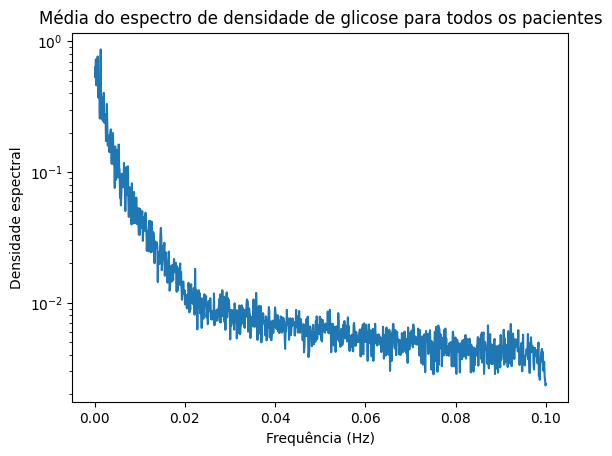

In [9]:
from scipy.fft import rfftfreq
import numpy as np
import matplotlib.pyplot as plt

fs = 1/5 # 1 kHz sampling frequency

densidades_espectrais = []
frequencias_totais = []

for i in range(all_data.shape[1]):
    glucose = all_data.iloc[:,i]
    glucose = glucose[~np.isnan(glucose)] # Removendo todos os NaN values


    frequencias = rfftfreq(len(glucose), 1/fs) #len patients e numero de amostras por s
    frequencias_totais = frequencias[1:]

    # Criar uma lista vazia para cada densidade espectral
    densidades_espectrais_atual = []

    Pxx = np.fft.rfft(glucose)
    Pxx = Pxx[1:]
    psd = np.abs(Pxx) / max(Pxx)

    for i, p in enumerate(psd):
        densidades_espectrais_atual.append(p)

    densidades_espectrais.append(densidades_espectrais_atual)

max_len = max([len(x) for x in densidades_espectrais])
for i in range(len(densidades_espectrais)):
    densidades_espectrais[i] += [0] * (max_len - len(densidades_espectrais[i]))

densidades_espectrais_media = np.mean(np.array(densidades_espectrais), axis=0)
densidades_espectrais_media = np.resize(densidades_espectrais_media, len(frequencias_totais))

print("Frequências: ", max(frequencias_totais))
print("PSD: ", max(densidades_espectrais_media))

for valor in densidades_espectrais_media:
    if valor == 0:
        break
    valor_anterior = valor

if valor_anterior is not None:
    print("O valor anterior ao primeiro valor igual a zero é:", valor_anterior)
else:
    print("Não há valores diferentes de zero na lista")

plt.semilogy(frequencias_totais, densidades_espectrais_media)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Densidade espectral')
plt.title('Média do espectro de densidade de glicose para todos os pacientes')
plt.show()


# Filtro

In [10]:
from scipy.signal import butter, filtfilt
def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

# Por exemplo, para aplicar o filtro na escala 3:
scale_to_filter = 300

# Defina a ordem do filtro de Butterworth
order = 3

# Defina a frequência de amostragem (amostras por unidade de tempo)
fs = 1/5

# Defina a frequência de corte do filtro de Butterworth (Hz)
fc = 0.05

# Defina o tipo de wavelet e o número de escalas desejadas
wavelet = 'db4'
num_scales = 4

threshold = 10

In [11]:
def data_prep(data, input_size, pred_horizon, is_train=True):
    """
    Prepare the input and target data for the LSTM model.
    """
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + input_size  # encontrar o final do padrão

        if not is_train: # output 0:P
            if end_ix > len(data)-1:
                break
            if np.isnan(np.sum(data[i:end_ix])) or np.isnan(data[end_ix]):
                continue
            # input e output do padrão
            seq_x, seq_y = data[i:end_ix], data[end_ix]
            
        elif is_train: # output P
            output_ix = end_ix + pred_horizon - 1 # output
            if output_ix > len(data)-1:
                break
            if np.isnan(np.sum(data[i:end_ix])) or np.isnan(data[output_ix]):
                continue
            # input e output do padrão
            seq_x, seq_y = data[i:end_ix], data[output_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)


In [12]:
from scipy.signal import butter, lfilter

def filtragem(data):
    # Define as frequências de corte do filtro de Butter
    lowcut = 0.01 # frequência de corte inferior em Hz
    highcut = 0.1 # frequência de corte superior em Hz

    # Aplica o filtro de Butter
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    order = 3
    b, a = butter(order, fc, btype='lowpass')
    filtered_data = lfilter(b, a, data)

    return filtered_data


In [13]:
def derivada (data):
    derivada = np.gradient(data)
    return derivada

In [14]:
def calcular_gradiente_manual(data):
    gradiente = np.diff(data)
    gradiente = np.insert(gradiente, 0, 0)  # Adicionar valor 0 no início do gradiente
    return gradiente


# Modelo

In [15]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Flatten
from keras import backend

def train_model(data, input_size, pred_horizon):
    # PARAMS
    activationfcn = 'sigmoid'
    activationfcn1 = 'linear'
    optimizerfcn = 'adam'
    lossfcn = 'mse'
    n_features = 1
    units = 4
    units1 = 1

    # input layer
    inputs = Input(shape=((input_size*2, n_features)))
    inputs = Flatten()(inputs)

    # passar o input para a hidden layer - parte nao linear
    dense = Dense(units=4, activation='sigmoid')
    hidden = Flatten()(dense(inputs))

    # obter o 1 output (o da camada de input) e juntar ao 2 output (o primeiro output esta a saltar a hidden layer) - parte linear
    jump = Concatenate(axis=1)([inputs, hidden])
    outputs = Dense(units=1, activation='linear')(jump)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizerfcn, loss=lossfcn)

    X_train = None  # Inicializar X_train como None antes do loop for
    y_train = None

    for i in range(0, np.size(data, 1)):
        data_filter = filtragem(data.iloc[:,i])
        data_filter = data_filter[~np.isnan(data_filter)] # Removendo todos os NaN values

        
        X, y = data_prep(data_filter, input_size, pred_horizon, True)
        X_dev, y_dev = data_prep(calcular_gradiente_manual(data_filter), input_size, pred_horizon, True)

        # Adicionar dimensão ao final dos arrays X e X_dev
        X = np.expand_dims(X, axis=-1)
        X_dev = np.expand_dims(X_dev, axis=-1)

        X_concat = np.concatenate((X, X_dev), axis=1)

        X_train = X_concat
        y_train = y

        if X_train.size != 0 and y_train.size != 0:
            # reshape de [padroes, n] para [padroes, n, n_features]
            #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
            
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
            X_train = np.expand_dims(X_train, axis=-1)

            model.fit(X_train, y_train, epochs=300, verbose=0)

    # Exibindo o score do modelo treinado
    score = model.evaluate(X_train, y_train, verbose=0)
    print('Score do modelo:', score)

    # Salvar modelo treinado em um arquivo
    model_path = 'models/' + str(input_size/12) + '_' + str(pred_horizon/12) + '.h5'
    model.save(model_path)
    print("Model --> ", model_path)

    backend.clear_session()


In [16]:

# Multiplicar os valores por 12 para obter as dimensões correspondentes em cada dado
input_sizes = [i*12 for i in n]
pred_horizontes = [p*12 for p in pred_horizons]
# Loop pelos diferentes input_sizes e pred_horizons
with tf.device('/cpu:0'):
    for input_size in input_sizes:
        for pred_horizon in pred_horizontes:
            # Chamar a função train_model com os parâmetros correspondentes
            train_model(train_data, input_size, pred_horizon)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Score do modelo: 762.6351928710938
Model -->  models/2.0_2.0.h5
Score do modelo: 2420.4033203125
Model -->  models/2.0_4.0.h5
Score do modelo: 2665.599853515625
Model -->  models/2.0_12.0.h5
Score do modelo: 810.536376953125
Model -->  models/4.0_2.0.h5
Score do modelo: 2396.191650390625
Model -->  models/4.0_4.0.h5
Score do modelo: 2685.959716796875
Model -->  models/4.0_12.0.h5
Score do modelo: 832.2664794921875
Model -->  models/6.0_2.0.h5
Score do modelo: 2415.887451171875
Model -->  models/6.0_4.0.h5
Score do modelo: 2894.257568359375
Model -->  models/6.0_12.0.h5
Score do modelo: 724.4306030273438
Model -->  models/8.0_2.0.h5
Score do modelo: 2107.130859375
Model -->  models/8.0_4.0.h5
Score do modelo: 2766.29296875
Model -->  models/8.0_12.0.h5
Score do modelo: 750.1131591796875
Model -->  models/12.0_2.0.h5
Score do modelo: 2287.373779296875
Model -->  models/12.0_4.0.h5
Score do modelo: 2911.66308

## Test

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and return the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(y_test.squeeze(), y_pred.squeeze())[0, 1]
    return mae, mse, corr

def test_model(data, input_size, pred_horizon):
    """
    Test the trained model on a group of test patients and save the evaluation metrics and plots.
    """
    # Load the trained model
    model_path = 'models/' + str(input_size/12) + '_' + str(pred_horizon/12)+ '.h5'
    model = keras.models.load_model(model_path)

    # Create directories to save the plots and evaluation results
    plots_path = 'plots/' + str(input_size/12) + '_' + str(pred_horizon/12)
    os.makedirs(plots_path, exist_ok=True)
    results_path = 'results/' + str(input_size/12) + '_' + str(pred_horizon/12)
    os.makedirs(results_path, exist_ok=True)

    for i in range(0, np.size(data, 1)):
        # Filter the data and prepare the test inputs and targets
        data_filter = filtragem(data.iloc[:, int(i)].values)
        data_filter = data_filter[~np.isnan(data_filter)] # Removendo todos os NaN values
        X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)
        X_test_dev, _ = data_prep(calcular_gradiente_manual(data_filter), input_size, pred_horizon, True)
        # Adicionar dimensão ao final dos arrays X e X_dev
        X_test = np.expand_dims(X_test, axis=-1)
        X_test_dev = np.expand_dims(X_test_dev, axis=-1)
        X_test_concat = np.concatenate((X_test, X_test_dev), axis=1)
        X_test_concat = X_test_concat.reshape((X_test_concat.shape[0], X_test_concat.shape[1], 1))

        # Make predictions
        y_pred = model.predict(X_test_concat)

        # Plot the data and predictions
        plt.plot(np.arange(len(data.iloc[:, int(i)].values))/12, data.iloc[:, int(i)].values, label='Original Data')
        plt.plot(np.arange(len(data_filter))/12, data_filter, label='Filtered Data')
        plt.plot((np.arange(input_size+pred_horizon-1, len(data_filter)))/12, y_test.squeeze(), label='True Values')
        plt.plot((np.arange(input_size+pred_horizon-1, len(data_filter)))/12, y_pred.squeeze(), label='Predictions')
        plt.legend()
        plt.savefig(os.path.join(plots_path, f'paciente_{i}.png'))
        plt.close()

        # Evaluate the model and save the results
        mae, mse, corr = evaluate_model(model, X_test_concat, y_test)
        with open(os.path.join(results_path, f'paciente_{i}.txt'), 'w') as f:
            f.write(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nCORR: {corr:.4f}')

    backend.clear_session()

In [21]:

# Multiplicar os valores por 12 para obter as dimensões correspondentes em cada dado
input_sizes = [i*12 for i in n]
pred_horizontes = [p*12 for p in pred_horizons]
# Loop pelos diferentes input_sizes e pred_horizons
for input_size in input_sizes:
    for pred_horizon in pred_horizontes:
        # Chamar a função train_model com os parâmetros correspondentes
        test_model(test_data, input_size, pred_horizon)

56/56 [==============================] - 0s 3ms/step


### AVG

In [22]:
import os
# Multiplicar os valores por 12 para obter as dimensões correspondentes em cada dado
input_sizes = [i*12 for i in n]
pred_horizontes = [p*12 for p in pred_horizons]
for horizon in pred_horizontes:
    for input_size in input_sizes:
        results_dir = f"results/{input_size/12}_{horizon/12}"

        # Criar dicionário para armazenar os resultados
        results_dict = {}

        # Percorrer todos os arquivos txt na pasta de resultados
        for file_name in os.listdir(results_dir):
            if file_name.endswith(".txt"):
                # Obter o nome do paciente a partir do nome do arquivo
                patient_name = file_name.split("_")[0]
                file_path = os.path.join(results_dir, file_name)
                with open(file_path, "r") as f:
                    # Ler os resultados do arquivo
                    results = [float(line.split(":")[1].strip()) for line in f.readlines()]
                # Adicionar os resultados ao dicionário
                if patient_name in results_dict:
                    results_dict[patient_name].append(results)
                else:
                    results_dict[patient_name] = [results]

        # Calcular a média dos resultados para cada paciente
        for patient_name, results_list in results_dict.items():
            # Calcular a média de cada métrica
            mae_list = [results[0] for results in results_list]
            mae_avg = sum(mae_list) / len(mae_list)
            mse_list = [results[1] for results in results_list]
            mse_avg = sum(mse_list) / len(mse_list)
            corr_list = [results[2] for results in results_list]
            corr_avg = sum(corr_list) / len(corr_list)
            # Salvar os resultados médios em um novo arquivo txt
            output_file_path = f"results/{input_size/12}_{horizon/12}/{patient_name}_avg.txt"
            with open(output_file_path, "w") as f:
                f.write(f"MAE: {mae_avg:.4f}\n")
                f.write(f"MSE: {mse_avg:.4f}\n")
                f.write(f"CORR: {corr_avg:.4f}\n")


In [29]:
import os
import csv

def generate_model_info_csv():
    result_path = 'results'
    output_csv_path = 'model_info.csv'

    # Get the list of folders in the results directory
    folders = os.listdir(result_path)

    # Initialize the data lists
    model_info = []

    # Iterate over the folders
    for folder in folders:
        folder_path = os.path.join(result_path, folder)
        if os.path.isdir(folder_path):
            # Extract input size and prediction horizon from the folder name
            input_size, pred_horizon = map(float, folder.split('_'))

            # Read the paciente_avg.txt file
            file_path = os.path.join(folder_path, 'paciente_avg.txt')
            with open(file_path, 'r') as f:
                lines = f.readlines()

            # Parse the metrics from the file
            mae = float(lines[0].split(':')[1].strip())
            mse = float(lines[1].split(':')[1].strip())
            corr = float(lines[2].split(':')[1].strip())

            # Append the data to the list
            model_info.append((input_size, pred_horizon, mae, mse, corr))

    # Sort the model info list by input_size and pred_horizon
    sorted_model_info = sorted(model_info, key=lambda x: (x[0], x[1]))

    # Write the data to a CSV file
    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Input Size', 'Prediction Horizon', 'MAE', 'MSE', 'CORR'])
        writer.writerows(sorted_model_info)

    print(f"Model information has been saved to '{output_csv_path}'.")

generate_model_info_csv()


Model information has been saved to 'model_info.csv'.


In [23]:
import os
# Definir pasta de resultados
results_folder = "results"
# Carregar os resultados de cada horizonte em uma lista
metrics = np.zeros((len(pred_horizons), len(n), 3))  # 3 métricas: MAE, MSE, correlação
# Multiplicar os valores por 12 para obter as dimensões correspondentes em cada dado
input_sizes = [i*12 for i in n]
pred_horizontes = [p*12 for p in pred_horizons]
for horizon in pred_horizontes:
    for input_size in input_sizes:
        folder_path = os.path.join(results_folder, f"{input_size/12}_{horizon/12}")
        result_file_path = os.path.join(folder_path, "paciente_avg.txt")
        with open(result_file_path, "r") as f:
                lines = f.readlines()
                mae = float(lines[0].split(": ")[1])
                mse = float(lines[1].split(": ")[1])
                corr = float(lines[2].split(": ")[1])
        metrics[i, j] = [mae, mse, corr]

# Calcular a correlação entre cada par de horizontes
correlations = np.zeros((len(pred_horizontes), len(pred_horizontes)))
for i in range(len(pred_horizontes)):
    for j in range(len(pred_horizontes)):
        x = metrics[i, :, 2]  # usar apenas a correlação como métrica
        y = metrics[j, :, 2]  # usar apenas a correlação como métrica
        correlations[i, j] = np.correlate(x, y)

# Encontrar o horizonte com a maior correlação com os outros horizontes
best_horizon_index = np.argmax(np.sum(correlations, axis=1))
best_horizon = pred_horizontes[best_horizon_index] / 12  # dividir por 12 para obter o valor em horas
best_input_index = np.argmax(np.sum(correlations, axis=0))
best_input = n[best_input_index]

# Imprimir o melhor horizonte
print(f"O melhor horizonte é {best_horizon} horas")
print(f"O melhor input é {best_input}")

NameError: name 'j' is not defined

### Plot

In [26]:
import os
import matplotlib.pyplot as plt

def plot_patient_results(patient_id):
    input_sizes = [i*12 for i in n]
    pred_horizontes = [p*12 for p in pred_horizons] 

    # Criar figura para plot dos resultados
    fig, axs = plt.subplots(len(input_sizes), len(pred_horizontes), figsize=(20, 20))
    fig.suptitle(f"Resultados do Paciente {patient_id}", fontsize=20)

    # Iterar sobre os input_sizes e pred_horizons e plotar resultados
    for i, input_size in enumerate(input_sizes):
        for j, pred_horizon in enumerate(pred_horizontes):
            # Nome do arquivo de plot correspondente
            plot_filename = f"plots/{input_size/12}_{pred_horizon/12}/paciente_{patient_id}.png"
            if os.path.exists(plot_filename):
                # Plotar o arquivo existente
                axs[i, j].imshow(plt.imread(plot_filename))
                axs[i, j].set_title(f"Input Size: {input_size/12}  Pred Horizon: {pred_horizon/12}")
    
    # Configurar os eixos e mostrar a figura
    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])
    plt.show()


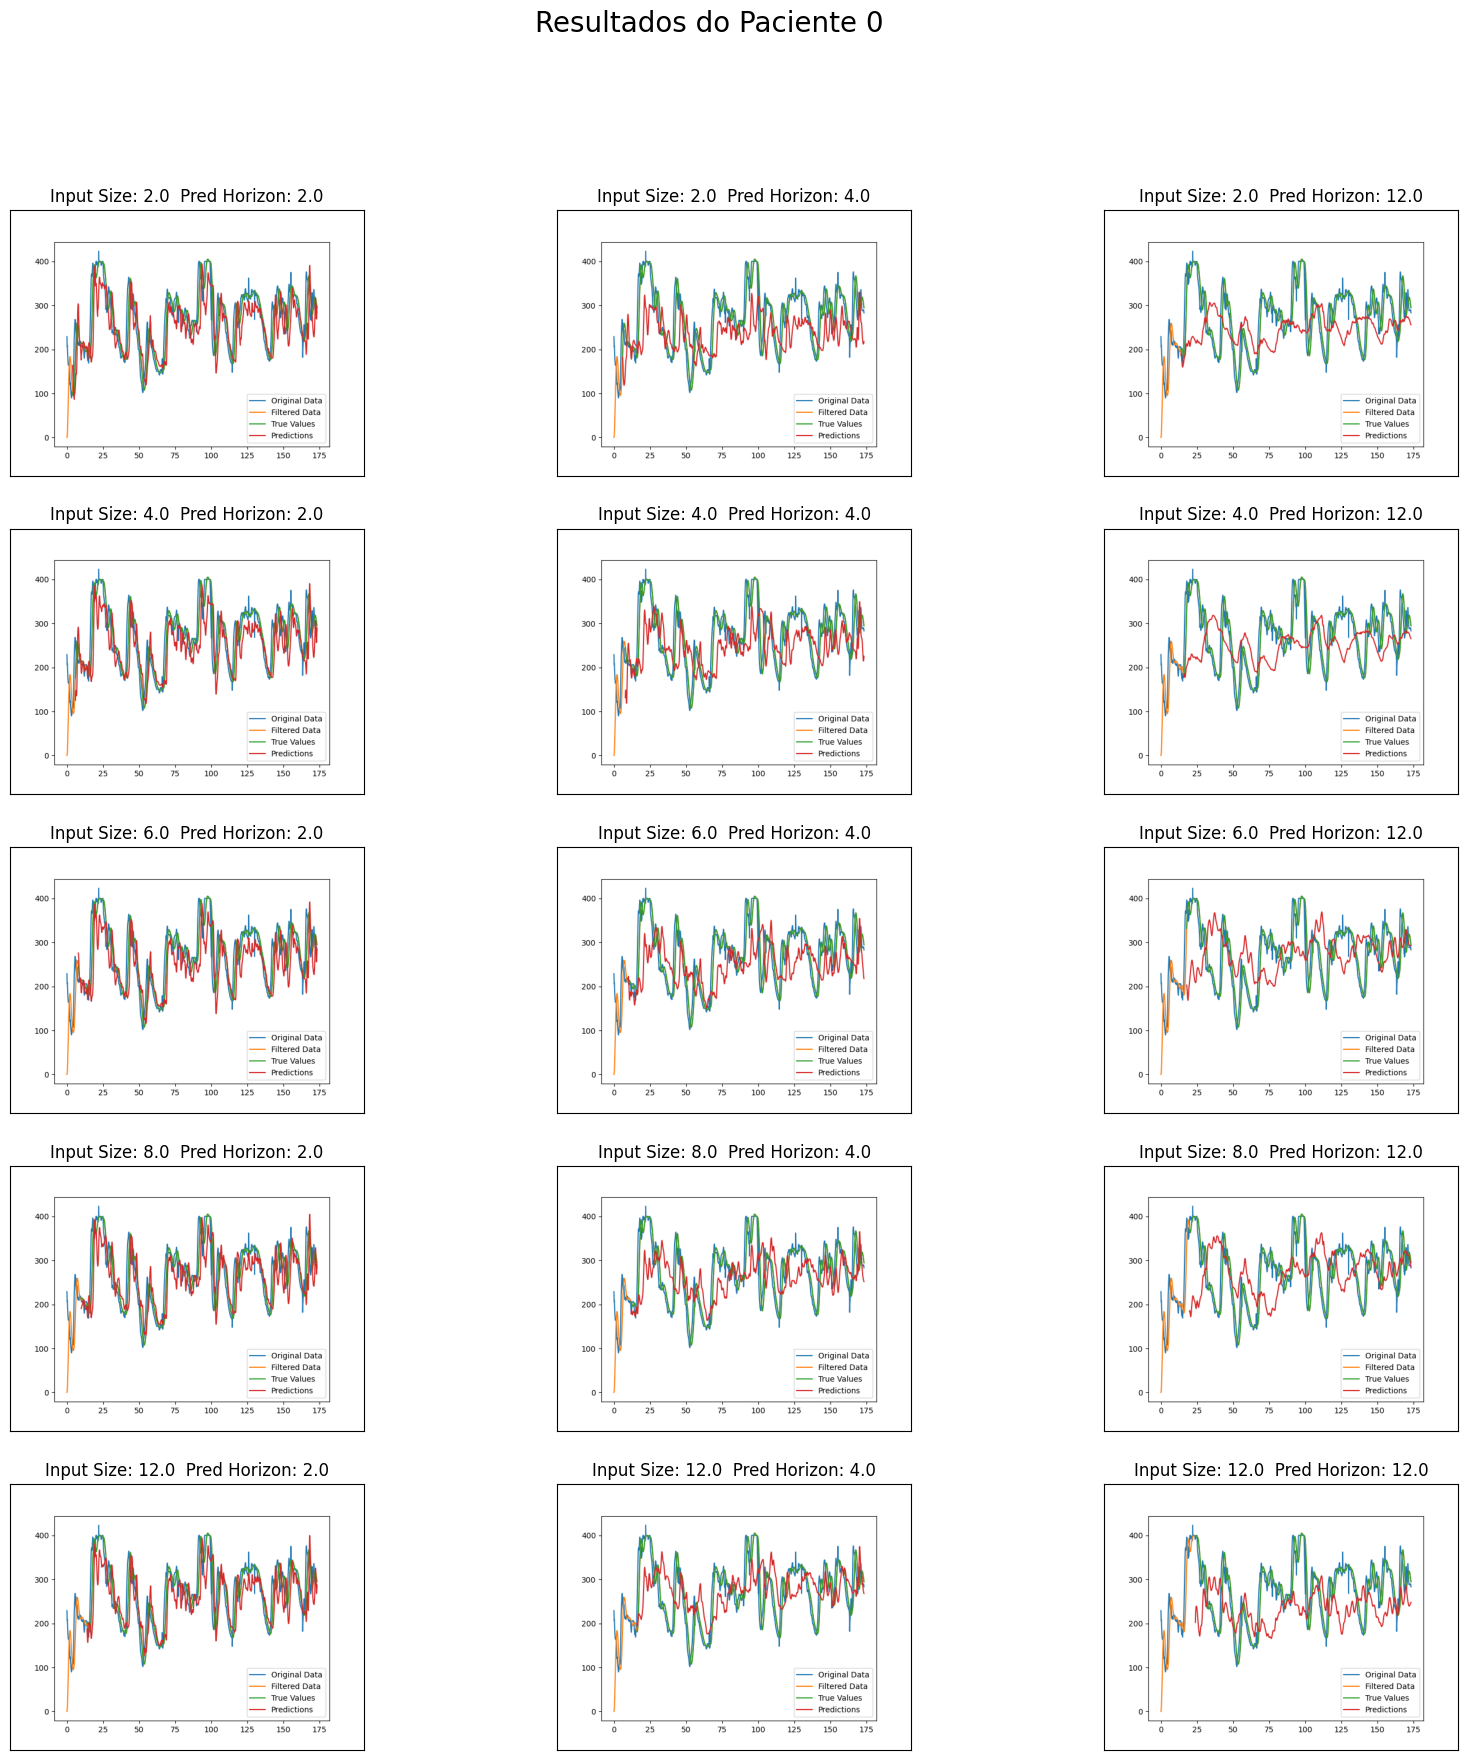

In [27]:
plot_patient_results(0)